<h1>Use linear regression to predict the age of abalone. <h1>




<h2>1 Description of the dataset and regression method used<h2>

The dataset url:http://archive.ics.uci.edu/ml/datasets/Abalone    
This dataset has 8 features: Sex、Length、Diameter、Height、Whole weight、Shucked weight、Viscera weight、Shell weight and one label: Rings. I hope to predict the rings from 8 features.

Here is the math theory and function I used in the regression.   
multiple linear regression:$$y = w_0+w_1x_1+...+w_nx_n$$      
the matrix style is:$$y = X^Tw$$
the loss function(I choose SSE, Sum of Squares for
Error): $$\sum_{i=1}^n (y_i-\hat{y_i})^2=\sum_{i=1}^n (y_i-X_i^Tw)^2$$   
the matrix style is:$$(y-X^Tw)^T(y-X^Tw)$$   
take the derivative of w and make it equal 0:$$X^T(y-Xw)=0$$  
$$\hat{w}=(X^TX)^{-1}X^Ty$$   
Because only the linear regression is poor, so I used Locally weighted linear regression to enhance it.   
Locally weighted linear regression: $$\hat{w}=(X^TWX)^{-1}X^TWy$$  
Here W is a matrix used to weight each data point.   
LWlR uses 'kernels' to give higher weights to nearby points. The most useful one is Gaussian kernel:$$w(i,i)=exp[\frac{|x^i-x|^2}{-2k^2}]$$

<h2>2 The code part<h2>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Input dataset (the last column is label), return characteristic matrix and label matrix
def get_Mat(dataSet):
    xMat = np.mat(dataSet.iloc[:,:-1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat

In [4]:
#Parameter Description:
#testMat: Test Set
#xMat: characteristic matrix of training set
#yMat: label matrix of training set
#return: yHat: function predicted value
def LWLR(testMat,xMat,yMat,k=1.0):
    n=testMat.shape[0]
    m=xMat.shape[0]
    weights =np.mat(np.eye(m))
    yHat = np.zeros(n)
    for i in range(n):
        for j in range(m):
            diffMat = testMat[i] - xMat[j]
            weights[j,j]=np.exp(diffMat*diffMat.T/(-2*k**2))
        xTx = xMat.T*(weights*xMat)
        if np.linalg.det(xTx)==0:
            print('it is a singular matrix, has no rank')
            return
        ws = xTx.I*(xMat.T*(weights*yMat))
        yHat[i]= testMat[i]*ws
    return yHat

In [5]:
#Import dataset
abalone = pd.read_csv('abalone.txt',header=None)
abalone.columns=['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']

In [11]:
#About the sex: Male = 1, Female = -1, infant = 0
abalone.head(10)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,-1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,-1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,-1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,0,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,1,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,1,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,-1,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,1,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


In [7]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   int64  
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


In [8]:
abalone.shape

(4177, 9)

In [13]:
xMat,yMat = get_Mat(abalone)
yHat = LWLR(xMat,xMat,yMat,k=1.0)

In [18]:
#Split train set and test set
def randSplit(dataSet,rate):
    m = dataSet.shape[0]
    n = int(m*rate)
    train = dataSet.iloc[:n,:]
    test = dataSet.iloc[n:m,:]
    test.index=range(test.shape[0])
    return train,test
train,test = randSplit(abalone,0.8)

In [19]:
#Calculate the sum of squares of errors SSE
def sseCal(yMat, yHat):
    sse = ((yMat.A.flatten()-yHat)**2).sum()
    return sse

In [20]:
#Because the amount of dataset is too large and the calculation speed is very slow, the first 100 data are selected as the training set, and the first 100-200 data are selected as the test set. Draw the SSE curves of training set and test set under different K values.
def showPlot(abalone):
    abX,abY = get_Mat(abalone)
    train_sse = []
    test_sse = []
    for k in np.arange(0.5,10.1,0.1):
        yHat1 = LWLR(abX[:99],abX[:99],abY[:99],k)
        sse1 = sseCal(abY[:99], yHat1)
        train_sse.append(sse1)

        yHat2 = LWLR(abX[100:199],abX[:99],abY[:99],k)
        sse2 = sseCal(abY[100:199], yHat2)
        test_sse.append(sse2)
    plt.plot(np.arange(0.5,10.1,0.1),train_sse,color='b')
    plt.plot(np.arange(0.5,10.1,0.1),test_sse,color='r')
    plt.xlabel('different k value')
    plt.ylabel('SSE')
    plt.legend(['train_sse','test_sse'])

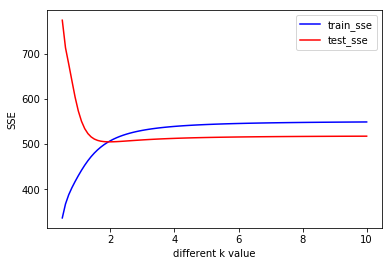

In [21]:
showPlot(abalone)

As the picture showed that, when k < 2(approximate), the model appears over fitting, and we can also conclusion that the best value of k should be 2(approximate).